In [3]:
import os
import warnings
warnings.filterwarnings('ignore')
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
from sklearn.model_selection import train_test_split
from scipy.sparse import coo_matrix
import math as mt
from scipy.sparse.linalg import * #used for matrix multiplication
from scipy.sparse.linalg import svds
from scipy.sparse import csc_matrix
from scipy.stats import skew, norm, probplot
import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
color = sns.color_palette()
sns.set_style('darkgrid')

### MSD 

In [6]:
song_df_1 = pd.read_csv('./data/kaggle_visible_evaluation_triplets.txt', sep='\t', header=None)
song_df_1.columns = ['user_id', 'song_id', 'listen_count']
song_df_1.head()

user_id             song_id  listen_count
0  fd50c4007b68a3737fe052d5a4f78ce8aa117f3d  SOBONKR12A58A7A7E0             1
1  fd50c4007b68a3737fe052d5a4f78ce8aa117f3d  SOEGIYH12A6D4FC0E3             1
2  fd50c4007b68a3737fe052d5a4f78ce8aa117f3d  SOFLJQZ12A6D4FADA6             1
3  fd50c4007b68a3737fe052d5a4f78ce8aa117f3d  SOHTKMO12AB01843B0             1
4  fd50c4007b68a3737fe052d5a4f78ce8aa117f3d  SODQZCY12A6D4F9D11             1

In [7]:
len(song_df_1)

1450933

In [8]:
### Loop the data lines
with open("./data/taste_profile_song_to_tracks.txt", 'r') as temp_f:
    # get No of columns in each line
    col_count = [ len(l.split("\t")) for l in temp_f.readlines() ]

### Generate column names  (names will be 0, 1, 2, ..., maximum columns - 1)
column_names = [i for i in range(0, max(col_count))]


df_pro = pd.read_table("./data/taste_profile_song_to_tracks.txt", delimiter="\t", names=column_names, header=None)
df_pro.columns = ['song_id','track_id','track_id1','track_id2']

df_pro

song_id            track_id track_id1 track_id2
0       SOAAADD12AB018A9DD  TRNCENP12903C9EF3A       NaN       NaN
1       SOAAADE12A6D4F80CC  TRSKKFK128F148B615       NaN       NaN
2       SOAAADF12A8C13DF62  TRCQMSP128F428A6F7       NaN       NaN
3       SOAAADZ12A8C1334FB  TRMDNZY128F425A532       NaN       NaN
4       SOAAAFI12A6D4F9C66  TRZEXLQ128F1491D17       NaN       NaN
...                    ...                 ...       ...       ...
386208  SOZZZRJ12AB0187A75  TRTMMRY12903CDE19D       NaN       NaN
386209  SOZZZRV12A8C1361F1  TRCEWAR128F425D1B6       NaN       NaN
386210  SOZZZSR12AB01854CD  TRPUDMM128F9308E1C       NaN       NaN
386211  SOZZZWD12A6D4F6624  TRJMEUS128F1458975       NaN       NaN
386212  SOZZZWN12AF72A1E29  TRLAYKX128F92E728C       NaN       NaN

[386213 rows x 4 columns]

In [9]:
song_df_2 = pd.read_table('./data/unique_tracks.txt', sep='<SEP>', header=None)
song_df_2.columns = ['track_id', 'song_id', 'artist_name', 'title']
song_df_2

track_id             song_id       artist_name  \
0       TRMMMYQ128F932D901  SOQMMHC12AB0180CB8  Faster Pussy cat   
1       TRMMMKD128F425225D  SOVFVAK12A8C1350D9  Karkkiautomaatti   
2       TRMMMRX128F93187D9  SOGTUKN12AB017F4F1    Hudson Mohawke   
3       TRMMMCH128F425532C  SOBNYVR12A8C13558C       Yerba Brava   
4       TRMMMWA128F426B589  SOHSBXH12A8C13B0DF        Der Mystic   
...                    ...                 ...               ...   
999995  TRYYYUS12903CD2DF0  SOTXAME12AB018F136      Kiko Navarro   
999996  TRYYYJO128F426DA37  SOXQYIQ12A8C137FBB     Kuldeep Manak   
999997  TRYYYMG128F4260ECA  SOHODZI12A8C137BB3    Gabriel Le Mar   
999998  TRYYYDJ128F9310A21  SOLXGOR12A81C21EB7             Elude   
999999  TRYYYVU12903CD01E3  SOWXJXQ12AB0189F43             Texta   

                                      title  
0                              Silent Night  
1                               Tanssi vaan  
2                         No One Could Ever  
3                             Si Vos Querés  
4                          Tangle Of Aspens  
...                                     ...  
999995                      O Samba Da Vida  
999996                         Jago Chhadeo  
999997                              Novemba  
999998                              Faraday  
999999  Fernweh feat. Sektion Kuchikäschtli  

[1000000 rows x 4 columns]

In [10]:
"The Scientist" in song_df_2["title"].values

True

In [11]:
song_df = pd.merge(song_df_1, song_df_2.drop_duplicates(['song_id']), on="song_id", how="left")
song_df.head()

user_id             song_id  listen_count  \
0  fd50c4007b68a3737fe052d5a4f78ce8aa117f3d  SOBONKR12A58A7A7E0             1   
1  fd50c4007b68a3737fe052d5a4f78ce8aa117f3d  SOEGIYH12A6D4FC0E3             1   
2  fd50c4007b68a3737fe052d5a4f78ce8aa117f3d  SOFLJQZ12A6D4FADA6             1   
3  fd50c4007b68a3737fe052d5a4f78ce8aa117f3d  SOHTKMO12AB01843B0             1   
4  fd50c4007b68a3737fe052d5a4f78ce8aa117f3d  SODQZCY12A6D4F9D11             1   

             track_id                                        artist_name  \
0  TRAEHHJ12903CF492F                                      Dwight Yoakam   
1  TRLGMFJ128F4217DBE  Barry Tuckwell/Academy of St Martin-in-the-Fie...   
2  TRTNDNE128F1486812                                            Cartola   
3  TRASTUE128F930D488                                      Lonnie Gordon   
4  TRFPLWO128F1486B9E                                        Miguel Calo   

                                               title  
0                                     You're The One  
1  Horn Concerto No. 4 in E flat K495: II. Romanc...  
2                                           Tive Sim  
3  Catch You Baby (Steve Pitron & Max Sanna Radio...  
4                                        El Cuatrero

In [12]:
song_df_1.count()

user_id         1450933
song_id         1450933
listen_count    1450933
dtype: int64

In [13]:
df_pro.count()

song_id      386213
track_id     383833
track_id1       669
track_id2        39
dtype: int64

In [14]:
df_pro['song_id'].value_counts()

SOAAADD12AB018A9DD    1
SOQSMDV12A58A7EA92    1
SOQSMQV12AF72A4EFC    1
SOQSMOP12AAF3B4902    1
SOQSMNL12A6D4F8113    1
                     ..
SOIBVTL12A8C14454B    1
SOIBVSJ12AB0182202    1
SOIBVQB12A6D4F8302    1
SOIBVPZ12A8C13F7BD    1
SOZZZWN12AF72A1E29    1
Name: song_id, Length: 386213, dtype: int64

In [15]:
df_pro['match_ct']=df_pro.count(axis=1)

In [16]:
df_pro['match_ct'].value_counts()

2    383164
1      2380
3       630
4        39
Name: match_ct, dtype: int64

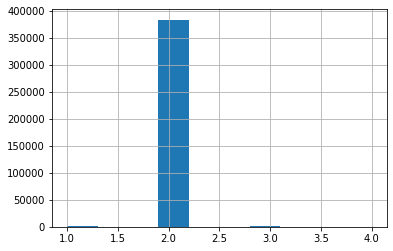

In [17]:
df_pro['match_ct'].hist()

In [18]:
song_df_1.groupby('song_id').sum().sort_values(by=['listen_count'], ascending=False)

listen_count
song_id                         
SOBONKR12A58A7A7E0         35432
SOAUWYT12A81C206F1         33179
SOSXLTC12AF72A7F54         24359
SOFRQTD12A81C233C0         19454
SOEGIYH12A6D4FC0E3         17115
...                          ...
SOKEJSK12AC468A801             1
SOUGBCY12AB01850C9             1
SOKEJSK12A6D4FC1EB             1
SOUGBJU12A6D4F83A4             1
SOMKDLE12A58A792AB             1

[163206 rows x 1 columns]

In [19]:
#unique songs (to track)
df_pro['song_id'].nunique()


386213

In [20]:
#unique songs (link to users)
song_df_1['song_id'].nunique()

163206

In [21]:
#unique user id
song_df_1['user_id'].nunique()

110000

In [22]:
song_df_2['artist_name'].nunique()

72665

In [23]:
song_df_2['track_id'].nunique()

1000000

### MXM Dataset

In [24]:
with open("./data/mxm_dataset_train.txt", 'r') as word_train_f:
    
    word_bag = dict()
    song_wordbag_list_train = list()
    for l in word_train_f:
        if l[0] != "#":
            #print(l)
            if l[0] == '%':
                word_bag_list = l[1:].strip().split(',')
                #print(word_bag_list)
            else:
                temp = l.strip().split(',')
                song_wordbag_list_train.append(temp)
                #print(temp)
                
    for idx, wd in enumerate(word_bag_list):
        word_bag[idx+1] = wd
        
    print(word_bag)

{1: 'i', 2: 'the', 3: 'you', 4: 'to', 5: 'and', 6: 'a', 7: 'me', 8: 'it', 9: 'not', 10: 'in', 11: 'my', 12: 'is', 13: 'of', 14: 'your', 15: 'that', 16: 'do', 17: 'on', 18: 'are', 19: 'we', 20: 'am', 21: 'will', 22: 'all', 23: 'for', 24: 'no', 25: 'be', 26: 'have', 27: 'love', 28: 'so', 29: 'know', 30: 'this', 31: 'but', 32: 'with', 33: 'what', 34: 'just', 35: 'when', 36: 'like', 37: 'now', 38: 'que', 39: 'time', 40: 'can', 41: 'come', 42: 'de', 43: 'there', 44: 'go', 45: 'up', 46: 'oh', 47: 'la', 48: 'one', 49: 'they', 50: 'out', 51: 'down', 52: 'get', 53: 'she', 54: 'was', 55: 'see', 56: 'if', 57: 'got', 58: 'never', 59: 'from', 60: 'he', 61: 'feel', 62: 'want', 63: 'let', 64: 'make', 65: 'way', 66: 'say', 67: 'take', 68: 'would', 69: 'as', 70: 'ca', 71: 'day', 72: 'at', 73: 'babi', 74: 'away', 75: 'life', 76: 'yeah', 77: 'y', 78: 'back', 79: 'by', 80: 'her', 81: 'heart', 82: 'here', 83: 'how', 84: 'could', 85: 'night', 86: 'need', 87: 'our', 88: 'look', 89: 'where', 90: 'en', 91: 'ey

In [25]:
song_wordbag_list_train

[['TRAAAAV128F421A322',
  '4623710',
  '1:6',
  '2:4',
  '3:2',
  '4:2',
  '5:5',
  '6:3',
  '7:1',
  '8:1',
  '11:1',
  '12:2',
  '13:3',
  '14:1',
  '15:1',
  '18:2',
  '19:2',
  '20:2',
  '21:2',
  '23:4',
  '25:1',
  '26:2',
  '28:1',
  '30:1',
  '36:2',
  '42:1',
  '45:1',
  '54:2',
  '56:1',
  '57:1',
  '68:1',
  '99:1',
  '192:2',
  '249:1',
  '264:1',
  '356:1',
  '389:1',
  '561:1',
  '639:1',
  '656:1',
  '687:1',
  '761:1',
  '773:1',
  '804:1',
  '869:2',
  '914:1',
  '1035:1',
  '1156:1',
  '1221:1',
  '1287:1',
  '1364:1',
  '1407:1',
  '1533:2',
  '1857:1',
  '2096:1',
  '2117:1',
  '2482:2',
  '2548:1',
  '2705:1',
  '2723:1',
  '2868:2',
  '2992:2',
  '3455:1',
  '3717:1',
  '3851:1',
  '4322:1',
  '4382:1',
  '4613:1',
  '4713:1',
  '4906:1'],
 ['TRAAABD128F429CF47',
  '6477168',
  '1:10',
  '3:17',
  '4:8',
  '5:2',
  '6:2',
  '7:1',
  '8:3',
  '9:2',
  '10:3',
  '11:4',
  '12:3',
  '14:7',
  '15:5',
  '16:5',
  '18:6',
  '23:4',
  '24:1',
  '26:6',
  '28:2',
  '29:5

In [26]:
song_wordbag_dict_train = dict()
for i in song_wordbag_list_train:
    song_wordbag_dict_train[i[0]] = {'mxm_id':i[1], 'ct':i[2:]}
    song_wordbag_dict_train[i[0]]['word_ct']= dict()
#print(song_wordbag_dict)


for i in song_wordbag_dict_train:
    for j in song_wordbag_dict_train[i]['ct']:
        t =j.split(':')
        akey = word_bag[int(t[0])]
        song_wordbag_dict_train[i]['word_ct'].update({akey: int(t[1])})
    song_wordbag_dict_train[i].pop('ct', None)


In [27]:
song_wordbag_dict_train['TRAAABD128F429CF47']

{'mxm_id': '6477168',
 'word_ct': {'a': 2,
  'after': 2,
  'alreadi': 2,
  'and': 2,
  'are': 6,
  'asleep': 1,
  'away': 2,
  'beat': 1,
  'believ': 1,
  'but': 3,
  'can': 1,
  'chang': 2,
  'could': 2,
  'day': 4,
  'deep': 4,
  'do': 5,
  'dream': 2,
  'everyth': 2,
  'fade': 2,
  'feel': 2,
  'find': 3,
  'for': 4,
  'get': 2,
  'goal': 2,
  'got': 3,
  'have': 6,
  'hear': 1,
  'heart': 5,
  'i': 10,
  'in': 3,
  'insid': 2,
  'is': 3,
  'it': 3,
  'keep': 3,
  'know': 5,
  'la': 7,
  'live': 1,
  'look': 2,
  'me': 1,
  'my': 4,
  'need': 3,
  'never': 2,
  'new': 1,
  'no': 1,
  'not': 2,
  'onli': 2,
  'our': 2,
  'pleas': 2,
  'so': 2,
  'someth': 4,
  'soul': 7,
  'start': 2,
  'style': 2,
  'that': 5,
  'there': 5,
  'thing': 2,
  'think': 1,
  'time': 3,
  'to': 8,
  'tri': 1,
  'true': 1,
  'trust': 1,
  'wanna': 3,
  'want': 2,
  'wast': 3,
  'what': 3,
  'when': 2,
  'where': 2,
  'while': 2,
  'wors': 2,
  'would': 2,
  'yeah': 4,
  'you': 17,
  'your': 7}}

In [28]:
with open("./data/mxm_dataset_test.txt", 'r') as word_train_f:
    
    word_bag = dict()
    song_wordbag_list_test = list()
    for l in word_train_f:
        if l[0] != "#":
            #print(l)
            if l[0] == '%':
                word_bag_list = l[1:].strip().split(',')
                #print(word_bag_list)
            else:
                temp = l.strip().split(',')
                song_wordbag_list_test.append(temp)
                #print(temp)
                
    for idx, wd in enumerate(word_bag_list):
        word_bag[idx+1] = wd
        
    print(word_bag)

{1: 'i', 2: 'the', 3: 'you', 4: 'to', 5: 'and', 6: 'a', 7: 'me', 8: 'it', 9: 'not', 10: 'in', 11: 'my', 12: 'is', 13: 'of', 14: 'your', 15: 'that', 16: 'do', 17: 'on', 18: 'are', 19: 'we', 20: 'am', 21: 'will', 22: 'all', 23: 'for', 24: 'no', 25: 'be', 26: 'have', 27: 'love', 28: 'so', 29: 'know', 30: 'this', 31: 'but', 32: 'with', 33: 'what', 34: 'just', 35: 'when', 36: 'like', 37: 'now', 38: 'que', 39: 'time', 40: 'can', 41: 'come', 42: 'de', 43: 'there', 44: 'go', 45: 'up', 46: 'oh', 47: 'la', 48: 'one', 49: 'they', 50: 'out', 51: 'down', 52: 'get', 53: 'she', 54: 'was', 55: 'see', 56: 'if', 57: 'got', 58: 'never', 59: 'from', 60: 'he', 61: 'feel', 62: 'want', 63: 'let', 64: 'make', 65: 'way', 66: 'say', 67: 'take', 68: 'would', 69: 'as', 70: 'ca', 71: 'day', 72: 'at', 73: 'babi', 74: 'away', 75: 'life', 76: 'yeah', 77: 'y', 78: 'back', 79: 'by', 80: 'her', 81: 'heart', 82: 'here', 83: 'how', 84: 'could', 85: 'night', 86: 'need', 87: 'our', 88: 'look', 89: 'where', 90: 'en', 91: 'ey

In [29]:
song_wordbag_list_test

[['TRAABRX12903CC4816',
  '1548880',
  '2:19',
  '4:7',
  '5:6',
  '10:1',
  '12:13',
  '13:6',
  '17:4',
  '18:6',
  '22:1',
  '23:1',
  '30:11',
  '32:4',
  '33:6',
  '46:8',
  '60:1',
  '73:1',
  '82:1',
  '89:1',
  '103:5',
  '116:1',
  '118:5',
  '134:1',
  '162:1',
  '184:1',
  '201:3',
  '212:5',
  '234:5',
  '260:3',
  '268:4',
  '274:4',
  '275:1',
  '279:4',
  '297:1',
  '351:6',
  '404:9',
  '449:4',
  '462:1',
  '484:4',
  '517:6',
  '521:5',
  '730:5',
  '814:1',
  '878:1',
  '1003:10',
  '1133:5',
  '1649:7',
  '2090:5',
  '2258:1',
  '2358:1',
  '2740:4',
  '3016:1',
  '3024:1',
  '3270:7',
  '3741:9',
  '4435:4'],
 ['TRAADFO128F92E1E91',
  '5325944',
  '1:79',
  '2:66',
  '3:15',
  '4:7',
  '5:8',
  '6:9',
  '7:5',
  '8:5',
  '9:4',
  '10:57',
  '11:5',
  '12:4',
  '13:2',
  '14:3',
  '15:2',
  '17:1',
  '18:6',
  '19:1',
  '20:56',
  '21:4',
  '22:3',
  '23:2',
  '24:1',
  '25:5',
  '28:6',
  '29:3',
  '30:2',
  '31:2',
  '32:5',
  '33:6',
  '34:4',
  '35:3',
  '36:4',

In [30]:
song_wordbag_dict_test = dict()
for i in song_wordbag_list_test:
    song_wordbag_dict_test[i[0]] = {'mxm_id':i[1], 'ct':i[2:]}
    song_wordbag_dict_test[i[0]]['word_ct']= dict()
#print(song_wordbag_dict)


for i in song_wordbag_dict_test:
    for j in song_wordbag_dict_test[i]['ct']:
        t =j.split(':')
        akey = word_bag[int(t[0])]
        song_wordbag_dict_test[i]['word_ct'].update({akey: int(t[1])})
    song_wordbag_dict_test[i].pop('ct', None)

In [31]:
song_wordbag_dict_test['TRAABRX12903CC4816']

{'mxm_id': '1548880',
 'word_ct': {'all': 1,
  'and': 6,
  'angel': 9,
  'are': 6,
  'babe': 5,
  'babi': 1,
  'bring': 3,
  'child': 6,
  'christ': 5,
  'christian': 1,
  'fear': 1,
  'feed': 1,
  'for': 1,
  'good': 1,
  'greet': 4,
  'guard': 5,
  'hast': 7,
  'he': 1,
  'here': 1,
  'him': 3,
  'in': 1,
  'is': 13,
  'keep': 5,
  'king': 5,
  'lamb': 1,
  'lap': 4,
  'lay': 4,
  'lie': 1,
  'mari': 10,
  'mean': 1,
  'of': 6,
  'oh': 8,
  'on': 4,
  'plead': 1,
  'rest': 4,
  'shepherd': 9,
  'silent': 1,
  'sing': 5,
  'sinner': 1,
  'sleep': 4,
  'son': 6,
  'such': 1,
  'sweet': 4,
  'the': 19,
  'this': 11,
  'to': 7,
  'watch': 5,
  'what': 6,
  'where': 1,
  'whi': 1,
  'while': 4,
  'who': 5,
  'whom': 7,
  'with': 4,
  'word': 1}}

### User

In [20]:
user_freq = song_df.groupby('user_id')['listen_count'].sum().reset_index().sort_values(by='listen_count', ascending=False)
user_freq

user_id  listen_count
2774   090b841eaf56d343a26625c2c6d08b823927bc4f           898
44766  957440a77858369fb7a6bcc6fa408fc187d5bd7b           574
34499  72e4442fb50d32acbe48252313f784c9182a0165           501
28523  5efa70adac9daff2303245322be33bc14c7361ed           452
9048   1dd2e5080f4c170c924ce1e91d3d41c1d80edc2f           440
...                                         ...           ...
41890  8bc07c0beda900cfac1951a26c4d99eca7001cf0             1
41885  8bbbb6369425f9aec27a12bfe01771524c2679ef             1
41880  8bb757727fc0f7977211b9cce157957c29415338             1
41873  8bb0e920078ca48191623565dd672ec820b11760             1
76839  ffff07d7d9bb187aa58c7b81b3d3f35e7cf7c0ee             1

[76840 rows x 2 columns]

Text(0, 0.5, 'Number of Users')

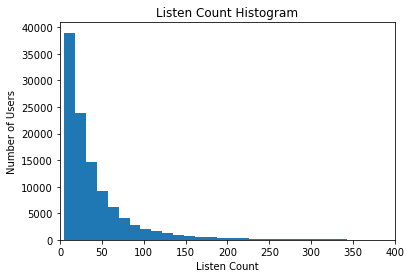

In [27]:
user_freq = song_df.groupby('user_id')['listen_count'].sum().reset_index()
user_freq['listen_count'].hist(bins=100)
plt.grid(False)
plt.xlim(0, 400)
plt.title('Listen Count Histogram')
plt.xlabel('Listen Count')
plt.ylabel('Number of Users')

In [10]:
user_freq.loc[2006]

user_id         04a4e9ae79fee7889a9d698c489590d78302e61b
listen_count                                          36
Name: 2006, dtype: object

In [16]:
song_df[song_df.user_id=='04a4e9ae79fee7889a9d698c489590d78302e61b'].sort_values(by='listen_count', ascending=False)[['title', 'genre','artist_name', 'listen_count']]

title genre    artist_name  listen_count
1357110  Just A Man  Rock  Faith No More            10

### Artist

In [7]:
import seaborn as sns

#set theme
sns.set_theme(style='white')

In [8]:
artist_df = song_df.groupby(['artist_name'])['listen_count'].agg(np.sum).to_frame()
artist_df = artist_df.reset_index()
artist_df

artist_name  listen_count
0                       !!!           325
1                  !Deladap             8
2              & And Oceans             9
3              '68 Comeback            49
4      'N Sync/Phil Collins           344
...                     ...           ...
28356          Étienne Daho           139
28357                   Íon            25
28358        Ólafur Arnalds           187
28359           Órla Fallon            10
28360           Özlem Tekin             1

[28361 rows x 2 columns]

In [9]:
artist_df = artist_df.sort_values(by='listen_count', ascending=True)
top_artist = artist_df.sort_values(by='listen_count', ascending=False).head(10)
top_artist = top_artist.reset_index(drop=True)
top_artist.to_csv('top_artist.csv',header=None, index=None)
top_artist

artist_name  listen_count
0           Kings Of Leon         35857
1           Dwight Yoakam         35688
2                   Björk         35210
3                Coldplay         32135
4  Florence + The Machine         28224
5           Justin Bieber         26133
6         Alliance Ethnik         21603
7                   Train         21356
8             OneRepublic         20802
9                Harmonia         19461

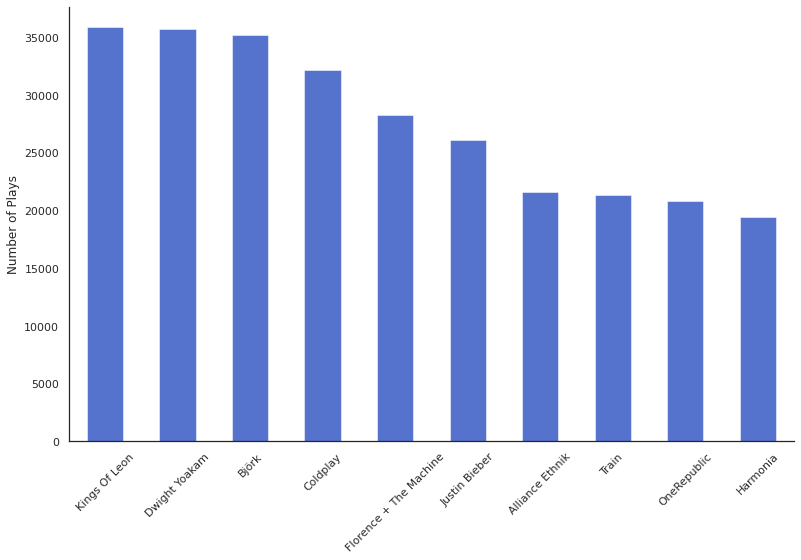

In [10]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (13,8))
ax = sns.barplot(top_artist['artist_name'], top_artist['listen_count'],color='royalblue',linewidth=0.5)
#ax = plt.bar(top_artist['artist_name'], top_artist['listen_count'],color='royalblue', align='center', width=0.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set(title = "",
      xlabel = "",
      ylabel = "Number of Plays")
plt.xticks(rotation=45)

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

change_width(ax, .5)

plt.show()

#plt.figure(figsize = (13,8))
#plt.title("Top 10 Artist by Number of Plays")
#plt.box(False)
#plt.xticks(rotation=45)
#plt.yticks([])
#plt.show()

In [11]:
artist_df.describe().T

count        mean         std  min  25%   50%   75%      max
listen_count  28361.0  163.052784  838.734575  1.0  4.0  17.0  77.0  35857.0

In [12]:
artist_df['play_range'] = np.nan

for i in range(artist_df.shape[0]):
  if artist_df.listen_count[i] <= 10:
    artist_df.play_range[i] = '1-10'
  elif artist_df.listen_count[i] <= 25:
    artist_df.play_range[i] = '10-25'
  elif artist_df.listen_count[i] <= 50:
    artist_df.play_range[i] = '25-50'
  elif artist_df.listen_count[i] <= 100:
    artist_df.play_range[i] = '50-100'
  elif artist_df.listen_count[i] <= 200:
    artist_df.play_range[i] = '100-200'
  elif artist_df.listen_count[i] <= 400:
    artist_df.play_range[i] = '200-400'
  elif artist_df.listen_count[i] <= 800:
    artist_df.play_range[i] = '400-800'
  elif artist_df.listen_count[i] <= 1000:
    artist_df.play_range[i] = '800-1000'
  elif artist_df.listen_count[i] <= 2000:
    artist_df.play_range[i] = '1000-2000'
  elif artist_df.listen_count[i] <= 5000:
    artist_df.play_range[i] = '2000-5000'
  elif artist_df.listen_count[i] <= 10000:
    artist_df.play_range[i] = '5000-10000'
  elif artist_df.listen_count[i] <= 15000:
    artist_df.play_range[i] = '10000-15000'
  elif artist_df.listen_count[i] <= 20000:
    artist_df.play_range[i] = '15000-20000'
  elif artist_df.listen_count[i] <= 25000:
    artist_df.play_range[i] = '20000-25000'
  elif artist_df.listen_count[i] <= 30000:
    artist_df.play_range[i] = '25000-30000'
  elif artist_df.listen_count[i] <= 35000:
    artist_df.play_range[i] = '30000-35000'
  else:
    artist_df.play_range[i] = '35000-40000'

In [13]:
artist_df.head()

artist_name  listen_count play_range
28360              Özlem Tekin             1       1-10
18368              Open Season             1       1-10
18369           Open Your Eyes             1       1-10
18375               Opgeduveld             1       1-10
18394  Orange Tulip Conspiracy             1       1-10

In [14]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (13,8))
ax = sns.histplot(artist_df.play_range, color='royalblue',binwidth=0.3)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set(title = "",
      xlabel = "Number of Plays (Binned)",
      ylabel = "Number of Artists")
plt.xticks(rotation=45)
#plt.ylim(0, 500)

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

change_width(ax, .8)

plt.show()

([<matplotlib.patches.Wedge at 0x7fa9e28d79d0>,
 [Text(-1.056932509116631, 0.3047846308008703, '1-10'),
  Text(-0.07317706887953768, -1.0975632631380297, '10-25'),
  Text(0.7878963385364455, -0.7676062530496108, '25-50'),
  Text(1.0957961519712223, -0.09607701767364724, '50-100'),
  Text(0.9730219777158555, 0.5130577266564899, '100-200'),
  Text(0.6607540768039187, 0.8794339372499798, '200-400'),
  Text(0.3792865980233469, 1.032541367965408, '400-800'),
  Text(0.2075962731217676, 1.080233209721842, '1000-2000'),
  Text(0.11590632795961191, 1.0938764661235376, '2000-5000'),
  Text(0.05371396582264162, 1.098687767236718, '800-1000'),
  Text(0.017058183346377733, 1.0998677276749789, '5000-10000'),
  Text(0.006457990514047353, 1.099981042726883, '10000-15000'),
  Text(0.0032899556139612597, 1.0999950800762968, '15000-20000'),
  Text(0.001827774849696014, 1.0999984814712696, '20000-25000'),
  Text(0.0010966830950098153, 1.0999994533117683, '35000-40000'),
  Text(0.00048743959072091266, 1.09

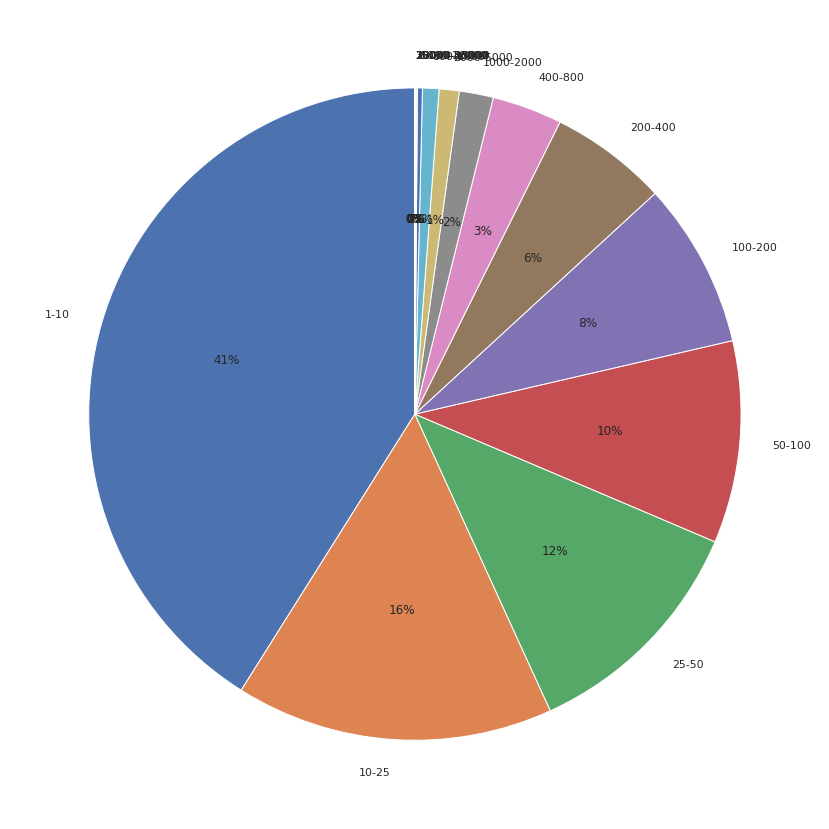

In [15]:
column_values = artist_df.play_range.value_counts()
labels = column_values.index
sizes = column_values.values
plt.figure(figsize = (15,15))
plt.pie(sizes, labels = labels, autopct = '%1.0f%%', startangle = 90)

### Location

In [32]:
location = pd.read_table("./data/artist_location.txt", sep='<SEP>', header=None)
location.columns = ['artisit_id','longitude','latitude', 'artist','loc'] ### not sure if the first column is artist id
location

artisit_id  longitude   latitude                artist  \
0      ARZGXZG1187B9B56B6  -16.96595  -61.14804          Endless Blue   
1      AR8K6F31187B99C2BC   46.44231  -93.36586               Go Fish   
2      ARHJJ771187FB5B581   51.59678   -0.33556  Screaming Lord Sutch   
3      ARJ8YLL1187FB3CA93   40.69626  -73.83301          Morton Gould   
4      ARYBAGV11ECC836DAC   43.58828  -79.64372        Crash Parallel   
...                   ...        ...        ...                   ...   
13845  ARY5A5U1187B9B2C08   34.05349 -118.24532            Rose Royce   
13846  AR02X7I1187FB41C6F   48.85692    2.34121                Shonky   
13847  ARJWB0K1187FB4D6ED  -36.55865  145.46900           Xavier Rudd   
13848  ARNEL2O1187FB4421A   33.89627  -89.00018           Bukka White   
13849  ARVSJ9A1187B9A1FF5   32.61436  -86.68073               Mr Mike   

                              loc  
0                      Santa Cruz  
1                 Twin Cities, MN  
2      Harrow, Middlesex, England  
3               Richmond Hill, NY  
4                     Mississauga  
...                           ...  
13845             Los Angeles, CA  
13846                Paris/Berlin  
13847         Victoria, Australia  
13848                 Houston, MS  
13849                     Alabama  

[13850 rows x 5 columns]

In [33]:
location['loc'].nunique()

3989

In [34]:
location['loc'].value_counts()

California - LA              374
NY - New York City           355
New York, NY                 272
London, England              230
Los Angeles, CA              213
                            ... 
Atamisqui, Argentina           1
MIAMI, FL                      1
CAPE CORAL, Florida            1
Brentwood, Essex, England      1
Houston, MS                    1
Name: loc, Length: 3989, dtype: int64

In [35]:
location['artist'].nunique()

13629

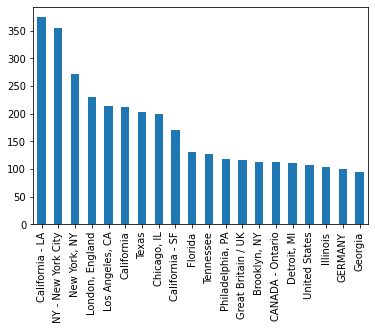

In [36]:
city_ct = location['loc'].value_counts()[:20]
city_ct.plot.bar()

In [37]:
location['artist'].value_counts()

King Tubby               4
Instrumental             4
Magnatune Compilation    3
Johnny Clarke            3
Pelt                     3
                        ..
Amnesia                  1
Tracey Thorn             1
Brand New                1
12 Stones                1
Mr Mike                  1
Name: artist, Length: 13629, dtype: int64

### Genre

In [7]:
genre = pd.read_table('./data/song_genre.cls', delimiter='\t', comment='#', header=None)
genre.columns = ['track_id','genre']
genre.head()

track_id  genre
0  TRAAAAK128F9318786   Rock
1  TRAAAAW128F429D538    Rap
2  TRAAADJ128F4287B47   Rock
3  TRAAADZ128F9348C2E  Latin
4  TRAAAED128E0783FAB   Jazz

In [13]:
genre['genre'].value_counts().plot.bar()
plt.xlabel('Genre')
plt.ylabel('Number of Songs')
plt.title('Genre Frequency Distribution')

Text(0.5, 1.0, 'Genre Frequency Distribution')

### Year

In [9]:
year = pd.read_table("./data/tracks_per_year.txt", sep='<SEP>', header=None)
year.columns = ['year','track_id','track_name','song_name']
year.head()

year            track_id       track_name            song_name
0  1922  TRSGHLU128F421DF83   Alberta Hunter         Don't Pan Me
1  1922  TRMYDFV128F42511FC  Barrington Levy   Warm And Sunny Day
2  1922  TRRAHXQ128F42511FF  Barrington Levy      Looking My Love
3  1922  TRFAFTK12903CC77B8  Barrington Levy   Warm And Sunny Day
4  1922  TRSTBUY128F4251203  Barrington Levy  Mandela You're Free

Text(0.5, 1.0, 'Year Frequency Distribution')

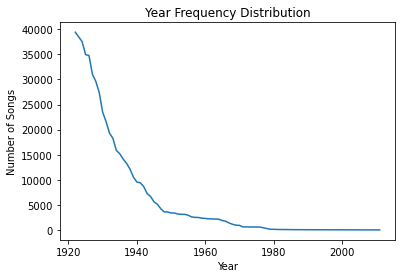

In [17]:
freq = year['year'].value_counts()
unique_year = year['year'].unique()
plt.plot(unique_year, freq)
plt.xlabel('Year')
plt.ylabel('Number of Songs')
plt.title('Year Frequency Distribution')

In [19]:
unique_year.min(), unique_year.max()

(1922, 2011)